# Spatial Homogenity of Manhattan

In [1]:
import pandas as pd
import numpy as np
import zipfile 
import pandas as pd
import geopandas as gp
import glob
import json
import pylab as pl
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from descartes import PolygonPatch
import sklearn.cluster
import os
import scipy 
from math import sqrt
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

%matplotlib inline

As a practice all the data is stored in PUIDATA

In [2]:
# Define environment variable PUIDATA to variable PUIDATA
PUIDATA = os.getenv('PUIDATA')

## Data Download and Prep

### 1. Zipcode geojson file 

In [3]:
fname = PUIDATA + '/nyc-zip-code-tabulation-areas-polygons.geojson'
nyc_shape = gp.read_file(fname).drop_duplicates(subset='postalCode')
# nyc_shape.plot(figsize=(5,5))  
nyczips = nyc_shape.postalCode.values.astype(int)
print ("number of NYC zip codes:", len(nyczips))   # Validating the number of zipcodes in NYC.

number of NYC zip codes: 247


In [4]:
#dropping coloumns not in need
nyc_shape.drop([  u'@id', u'BLDGpostalCode', u'ST_FIPS', u'STATE',   u'PO_NAME', u'CTY_FIPS',
             u'OBJECTID', u'Shape_Area', u'Shape_Leng'], axis = 1, inplace = True) 

#renaming the name postalcode with zip 
nyc_shape = nyc_shape.rename(columns={'postalCode' : 'ZipCode'}) 

# convert the zip to numeric format.
nyc_shape['ZipCode'] = pd.to_numeric(nyc_shape['ZipCode'])
nyc_shape = nyc_shape[nyc_shape['borough'] == 'Manhattan']
nyc_shape.head()

,borough,geometry,ZipCode
49,Manhattan,"POLYGON ((-73.92062094847111 40.873001790648, ...",10034
50,Manhattan,POLYGON ((-73.93213126627553 40.86945065275044...,10033
52,Manhattan,"POLYGON ((-73.93378898818895 40.8630718729956,...",10040
60,Manhattan,POLYGON ((-73.94691631035546 40.85053396462935...,10032
64,Manhattan,POLYGON ((-73.94008773907041 40.83034967785467...,10031


### 2. Manhattan PLUTO data

In [6]:
MN = pd.read_csv('BORO_zip_files_csv/MN.csv')
MN.head(3)

/Users/shalmali/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2


#### Select only required columns from the 70 attributes

In [7]:
MN = MN[['ZipCode','LandUse','IrrLotCode',
       'BldgClass', 'BldgArea', 'LotArea','NumFloors', 
        'BldgFront','BldgDepth']]
MN.head(3)

,ZipCode,LandUse,IrrLotCode,BldgClass,BldgArea,LotArea,NumFloors,BldgFront,BldgDepth
0,10004.0,8.0,N,Y4,2725731,7736692,0.0,0.0,0.0
1,10004.0,8.0,Y,P7,541886,541886,0.0,0.0,0.0
2,10004.0,NaN,N,Z9,603130,2764190,0.0,0.0,0.0


In [8]:
MN.ZipCode.unique()

array([ 10004.,     nan,  10006.,  10280.,  10282.,  10281.,  10007.,
        10005.,  10038.,  10045.,  10013.,  10002.,  10009.,  10003.,
        10012.,  10014.,  10011.,  10001.,  10018.,  10119.,  10123.,
        10010.,  10118.,  10016.,  10017.,  10036.,  10019.,  10020.,
        10023.,  10024.,  10069.,  10025.,  10112.,  10103.,  10022.,
        10044.,  10065.,  10021.,  10075.,  10028.,  10128.,  10026.,
        10029.,  10035.,  10129.,  10027.,  10037.,  10039.,  10030.,
        10031.,  10032.,  10033.,  10040.,  10034.,  10463.])

In [9]:
MN = MN[MN['ZipCode'] != 10463]

In [10]:
MN.dropna(inplace=True, subset=['ZipCode'])

In [11]:
len(MN.ZipCode.unique())

53

### Calculate the Standard deviation for the selected attributes

In [12]:
MN['IrrLotCode'] = pd.Categorical(MN.IrrLotCode).codes
irr = MN.groupby(['ZipCode'])['IrrLotCode'].std()
irr.head(3)

ZipCode
10001.0    0.446560
10002.0    0.472918
10003.0    0.445456
Name: IrrLotCode, dtype: float64

In [13]:
depthMN = MN.groupby(['ZipCode'])['BldgDepth'].std()
depthMN.head(3)

ZipCode
10001.0    73.761979
10002.0    41.972632
10003.0    38.957719
Name: BldgDepth, dtype: float64

In [14]:
Bldg_ht = MN.groupby(['ZipCode'])['NumFloors'].std()
Bldg_ht.head(3)

ZipCode
10001.0    7.798364
10002.0    3.878105
10003.0    3.656431
Name: NumFloors, dtype: float64

In [15]:
front = MN.groupby(['ZipCode'])['BldgFront'].std()
front.head(3)

ZipCode
10001.0    72.186163
10002.0    43.249877
10003.0    36.037188
Name: BldgFront, dtype: float64

In [16]:
df = pd.concat([Bldg_ht,front,depthMN,irr],axis=1)
df.head(3)

,NumFloors,BldgFront,BldgDepth,IrrLotCode
ZipCode,,,,
10001.0,7.798364,72.186163,73.761979,0.446560
10002.0,3.878105,43.249877,41.972632,0.472918
10003.0,3.656431,36.037188,38.957719,0.445456


In [17]:
df.reset_index()

,ZipCode,NumFloors,BldgFront,BldgDepth,IrrLotCode
0,10001.0,7.798364,72.186163,73.761979,0.446560
1,10002.0,3.878105,43.249877,41.972632,0.472918
2,10003.0,3.656431,36.037188,38.957719,0.445456
3,10004.0,14.971565,81.152684,94.283673,0.268680
4,10005.0,15.838469,93.217189,103.047778,0.268194
5,10006.0,14.379807,49.932474,76.363221,0.242186
6,10007.0,13.161381,70.299937,69.578247,0.477246
7,10009.0,2.369888,49.564359,63.661497,0.359706
8,10010.0,7.293560,46.862394,56.757986,0.421028
9,10011.0,3.505930,37.513697,55.067405,0.411736


In [18]:
df.dropna(inplace=True, subset=['NumFloors','BldgFront','BldgDepth','IrrLotCode'])
df.shape

(49, 4)

The PLUTO data is now clean and ready to be normalised by using sklearn preprocessing package.

In [19]:
from sklearn import preprocessing
df_norm = preprocessing.MinMaxScaler()
df_scaled = df_norm.fit_transform(df)

In [20]:
df1 = pd.DataFrame(df_scaled)

In [21]:
df1.head(3)

,0,1,2,3
0,0.272184,0.211345,0.184288,0.773464
1,0.085004,0.072209,0.052386,0.819118
2,0.074420,0.037528,0.039876,0.771552


In [22]:
df1.index = df.index
df1['ZipCode'] = df1.index
df1.reset_index
df1.head(3)

,0,1,2,3,ZipCode
ZipCode,,,,,
10001.0,0.272184,0.211345,0.184288,0.773464,10001.0
10002.0,0.085004,0.072209,0.052386,0.819118,10002.0
10003.0,0.074420,0.037528,0.039876,0.771552,10003.0


In [23]:
df1.iloc[:,1:]
df1.head(3)

,0,1,2,3,ZipCode
ZipCode,,,,,
10001.0,0.272184,0.211345,0.184288,0.773464,10001.0
10002.0,0.085004,0.072209,0.052386,0.819118,10002.0
10003.0,0.074420,0.037528,0.039876,0.771552,10003.0


In [24]:
df1.drop(['ZipCode'], axis = 1, inplace = True)
df1.head(2)

,0,1,2,3
ZipCode,,,,
10001.0,0.272184,0.211345,0.184288,0.773464
10002.0,0.085004,0.072209,0.052386,0.819118


In [25]:
df1 = df1.reset_index()
df1.head(2)

,ZipCode,0,1,2,3
0,10001.0,0.272184,0.211345,0.184288,0.773464
1,10002.0,0.085004,0.072209,0.052386,0.819118


In [26]:
len(df1.ZipCode.unique())

49

#### Merge the data with geojson file

In [28]:
#nyc_shape.index = nyc_shape.ZipCode
mn_zip = nyc_shape.merge(df1,on ='ZipCode', how='outer')

In [29]:
mn_zip.head()

,borough,geometry,ZipCode,0,1,2,3
0,Manhattan,"POLYGON ((-73.92062094847111 40.873001790648, ...",10034.0,0.012594,0.136119,0.110080,0.822262
1,Manhattan,POLYGON ((-73.93213126627553 40.86945065275044...,10033.0,0.022046,0.088301,0.052985,0.809672
2,Manhattan,"POLYGON ((-73.93378898818895 40.8630718729956,...",10040.0,0.019057,0.137704,0.060926,0.840027
3,Manhattan,POLYGON ((-73.94691631035546 40.85053396462935...,10032.0,0.026393,0.097626,0.054745,0.780752
4,Manhattan,POLYGON ((-73.94008773907041 40.83034967785467...,10031.0,0.001564,0.055250,0.015642,0.592347


In [30]:
mn_zip.isnull().sum()

borough      1
geometry     1
ZipCode      0
0           57
1           57
2           57
3           57
dtype: int64

In [31]:
mn_zip.dropna(inplace=True)
mn_zip.shape

(48, 7)

In [32]:
mn_zip.rename(columns={'0':'NumFloors', '1':'BldgFront', '2':'BldgDepth', '3':'IrrLotCode'},inplace=True)

The dataframe is clean and ready for clustering analysis.

## KMeans Clustering 

In [34]:
X = mn_zip.iloc[:, 3:7]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".\
          format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.481942826644951
For n_clusters =3, the average silhouette_score is :0.49829766832402234
For n_clusters =4, the average silhouette_score is :0.4336857963692444
For n_clusters =5, the average silhouette_score is :0.37811692930824475
For n_clusters =6, the average silhouette_score is :0.3640841886109711
For n_clusters =7, the average silhouette_score is :0.35172781181404406
For n_clusters =8, the average silhouette_score is :0.35168057738126834
For n_clusters =9, the average silhouette_score is :0.3571896239041697


In [35]:
# number of clusters = 4 
nc = 4
kmeans_cluster = KMeans(n_clusters=nc, random_state=324).fit(X)
centers = kmeans_cluster.cluster_centers_
mn_zip['km_labels'] = kmeans_cluster.labels_

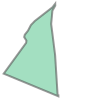

In [36]:
mn_zip.geometry[5]

In [38]:
mn_zip = pd.read_csv('Manhattan_clustering.csv')
mn_zip['sum'] = mn_zip.NumFloors + mn_zip.BldgFront + mn_zip.BldgDepth + mn_zip.IrrLotCode
mn_zip.head(2)

,Unnamed: 0,borough,geometry,ZipCode,NumFloors,BldgFront,BldgDepth,IrrLotCode,km_labels,sum
0,0,Manhattan,"POLYGON ((-73.92062094847111 40.873001790648, ...",10034,0.012594,0.136119,0.110080,0.822262,3,1.081055
1,1,Manhattan,POLYGON ((-73.93213126627553 40.86945065275044...,10033,0.022046,0.088301,0.052985,0.809672,3,0.973005


In [39]:
mn_zip.drop('Unnamed: 0', axis=1,inplace=True)
mn_zip.head(2)

,borough,geometry,ZipCode,NumFloors,BldgFront,BldgDepth,IrrLotCode,km_labels,sum
0,Manhattan,"POLYGON ((-73.92062094847111 40.873001790648, ...",10034,0.012594,0.136119,0.110080,0.822262,3,1.081055
1,Manhattan,POLYGON ((-73.93213126627553 40.86945065275044...,10033,0.022046,0.088301,0.052985,0.809672,3,0.973005


## DBSCAN Clustering 

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
db = DBSCAN(eps=0.1).fit(X)
mn_zip['db_labels'] = (db.labels_).astype(int)

In [42]:
n_clusters = len(set(mn_zip['db_labels'])) - (1 if -1 in mn_zip['db_labels'] else 0)
print ('Number of clusters :', n_clusters)

Number of clusters : 4


In [47]:
mn_zip.to_csv('Output/Cluster_labels.csv')

### The zip codes in each of the clusters.

In [43]:
mn_zip_lst = mn_zip.ZipCode.values.astype(str)

In [65]:
for j in range(-1,3):
    print ("zipcodes in cluster", j)
    print (mn_zip_lst[db.labels_==j])

zipcodes in cluster -1
['10016' '10119']
zipcodes in cluster 0
['10034' '10033' '10040' '10031' '10039' '10030' '10027' '10037' '10024'
 '10026' '10035' '10025' '10029' '10128' '10023' '10028' '10044' '10036'
 '10018' '10020' '10017' '10001' '10011' '10010' '10014' '10003' '10002'
 '10009' '10012' '10013' '10007' '10038' '10006' '10005' '10004' '10280'
 '10019' '10103' '10075' '10069' '10281']
zipcodes in cluster 1
['10032' '10021' '10022' '10065']
zipcodes in cluster 2
[]


/Users/shalmali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 48 but corresponding boolean dimension is 47
  app.launch_new_instance()


In [45]:
for j in range(4):
    print ("zipcodes in cluster", j)
    print (mn_zip_lst[km.labels_==j])

zipcodes in cluster 0
['10031' '10039' '10030' '10027' '10037' '10024' '10026' '10035' '10025'
 '10029' '10128' '10023' '10021' '10009' '10065' '10075']
zipcodes in cluster 1
['10020' '10103' '10281']
zipcodes in cluster 2
['10006' '10005' '10004' '10280' '10069' '10282']
zipcodes in cluster 3
['10044']


The maps were created using Cartodb. 

## Adding Population Data

In [48]:
pop = pd.read_csv('population_zip.csv')
pop.head(2)

,FIPS,Area Name-Legal/Statistical Area Description,Logical Record Number,State (FIPS),ZIP Code Tabulation Area (5 digit),Population Density (per sq. mile)
0,Geo_FIPS,Geo_NAME,Geo_LOGRECNO,Geo_STATE,Geo_ZCTA5,SE_T002_002
1,3610001,ZCTA5 10001,471365,36,10001,33959.17


In [49]:
pop = pop.iloc[1:,:]

In [50]:
pop.head(3)

,FIPS,Area Name-Legal/Statistical Area Description,Logical Record Number,State (FIPS),ZIP Code Tabulation Area (5 digit),Population Density (per sq. mile)
1,3610001,ZCTA5 10001,471365,36,10001,33959.17
2,3610002,ZCTA5 10002,471367,36,10002,92573.08
3,3610003,ZCTA5 10003,471369,36,10003,97187.61


In [51]:
pop.rename(columns= {'ZIP Code Tabulation Area (5 digit)': 'ZipCode'}, inplace=True)

In [52]:
pop.ZipCode.dtype

dtype('O')

In [53]:
pop['ZipCode'] = pop.ZipCode.astype(int)

In [54]:
mn_df = pop.merge(mn_zip, on='ZipCode',how= 'inner' )
mn_df.head(3)

,FIPS,Area Name-Legal/Statistical Area Description,Logical Record Number,State (FIPS),ZipCode,Population Density (per sq. mile),borough,geometry,NumFloors,BldgFront,BldgDepth,IrrLotCode,km_labels,sum,db_labels
0,3610001,ZCTA5 10001,471365,36,10001,33959.17,Manhattan,POLYGON ((-74.00827017711134 40.75258714368449...,0.272184,0.211345,0.184288,0.773464,3,1.441281,-1
1,3610002,ZCTA5 10002,471367,36,10002,92573.08,Manhattan,POLYGON ((-73.97441674489379 40.73642441865476...,0.085004,0.072209,0.052386,0.819118,3,1.028718,0
2,3610003,ZCTA5 10003,471369,36,10003,97187.61,Manhattan,POLYGON ((-73.97986374196766 40.73497446573838...,0.074420,0.037528,0.039876,0.771552,3,0.923377,0


In [55]:
mn_df.shape

(47, 15)

In [56]:
mn_df = mn_df[['ZipCode','Population Density (per sq. mile)','sum', 'geometry']]

In [57]:
mn_df.head(3)

,ZipCode,Population Density (per sq. mile),sum,geometry
0,10001,33959.17,1.441281,POLYGON ((-74.00827017711134 40.75258714368449...
1,10002,92573.08,1.028718,POLYGON ((-73.97441674489379 40.73642441865476...
2,10003,97187.61,0.923377,POLYGON ((-73.97986374196766 40.73497446573838...


In [58]:
mn_df.rename(columns={'sum':'div_score','Population Density (per sq. mile)':'Pop_density'},inplace=True)

In [59]:
mn_df.head(3)

,ZipCode,Pop_density,div_score,geometry
0,10001,33959.17,1.441281,POLYGON ((-74.00827017711134 40.75258714368449...
1,10002,92573.08,1.028718,POLYGON ((-73.97441674489379 40.73642441865476...
2,10003,97187.61,0.923377,POLYGON ((-73.97986374196766 40.73497446573838...


In [60]:
mn_df.Pop_density = mn_df.Pop_density.astype(float)

In [61]:
X = mn_df.iloc[:, 1:2]
range_n_clusters = range(2,15)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".\
          format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5557222941581142
For n_clusters =3, the average silhouette_score is :0.5462770942307834
For n_clusters =4, the average silhouette_score is :0.570107107819348
For n_clusters =5, the average silhouette_score is :0.5698623567528384
For n_clusters =6, the average silhouette_score is :0.5834983876641345
For n_clusters =7, the average silhouette_score is :0.5995944494092975
For n_clusters =8, the average silhouette_score is :0.6118378430000373
For n_clusters =9, the average silhouette_score is :0.6373836986478135
For n_clusters =10, the average silhouette_score is :0.6372151163991274
For n_clusters =11, the average silhouette_score is :0.6389324696369244
For n_clusters =12, the average silhouette_score is :0.6155828383891108
For n_clusters =13, the average silhouette_score is :0.6153479509100714
For n_clusters =14, the average silhouette_score is :0.6122009465781809


In [62]:
# number of clusters = 8
nc = 8
kmeans_cluster = KMeans(n_clusters=nc, random_state=324).fit(X)
centers = kmeans_cluster.cluster_centers_
mn_df['km_labels'] = kmeans_cluster.labels_

In [63]:
db = DBSCAN(eps=14900).fit(X)
mn_df['db_labels'] = (db.labels_).astype(int)

In [64]:
n_clusters = len(set(mn_df['db_labels'])) - (1 if -1 in mn_df['db_labels'] else 0)
print ('Number of clusters :', n_clusters)

Number of clusters : 3


In [ ]:
mn_df.to_csv('clustering.csv')